In [1]:
%matplotlib inline
from parcels import Field, FieldSet, ParticleSet,Variable, JITParticle, plotTrajectoriesFile, AdvectionRK4,ErrorCode
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rc, animation
import xarray as xr
from scipy.special import entr

from IPython.display import Image
rc('animation', html='html5')


In [2]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.time}, {particle.depth}, {particle.lat}, {particle.lon}]')
    particle.delete()

In [3]:
class MPParticle(JITParticle):
    surf = Variable('surf', initial =  0.0) 


In [4]:
def tu_mix(particle,fieldset,time):
    bath= 109.73707
    if particle.depth+0.5 > bath: #Only calculate gradient of diffusion for particles deeper than 0.6 otherwise OP will check for particles outside the domain and remove it.
        Kzdz = 2*(fieldset.Kz[time,particle.depth,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth-0.5,particle.lat, particle.lon]) #forward difference 
    else: 
        Kzdz = 2*(fieldset.Kz[time,particle.depth+0.5,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth,particle.lat, particle.lon]) #forward difference 
    dgrad = Kzdz * particle.dt 
    if particle.depth+0.5*dgrad > 0:
        kk = fieldset.Kz[time,particle.depth+0.5*dgrad,particle.lat, particle.lon] #Vertical diffusivity SSC  #
    else:
        kk = fieldset.Kz[time, 0,particle.lat, particle.lon] #Vertical diffusivity SSC  #
    Kx = 1.5
    Rr = ParcelsRandom.uniform(-1, 1)
    Rr2 = ParcelsRandom.uniform(-1, 1)
    d_random = sqrt(3*2*kk*particle.dt) * Rr
    d_randomx = sqrt(3*2*Kx*particle.dt) * Rr2
    Dlayerz = 0.5*sqrt(kk * particle.dt) #1m mixing layer
    Dlayerx = 0.5*sqrt(Kx * particle.dt)
    if particle.lon + d_randomx < 0:
        particle.lon = Dlayerx * ParcelsRandom.uniform(0, 1)
    elif particle.lon + d_randomx > 2e3:
        particle.lon = 2e3 - Dlayerx * ParcelsRandom.uniform(0, 1)
    else: 
        particle.lon=particle.lon + d_randomx
    if particle.surf == 0 :
        if d_random + dgrad +particle.depth > bath: #randomly in the water column
            particle.depth = bath - Dlayerz * ParcelsRandom.uniform(0, 1)
        elif d_random +particle.depth +dgrad < 0:
                if ParcelsRandom.uniform(0,1)<0.1:
                    particle.surf = 1
                    particle.depth = 0
                else:
                    particle.depth = Dlayerz * ParcelsRandom.uniform(0, 1) #Well mixed boundary layer
        else:
            particle.depth += d_random + dgrad 
        particle.depth+= particle.dt*40/86400
        if particle.depth>=bath:
            particle.surf = 2
            particle.depth =bath
    # else:
    #     Ub = 2*86400  #timescale resuspend
    #     Pr = 1 - exp(-particle.dt/Ub)
    #     if ParcelsRandom.uniform(0,1)<Pr:
    #         if particle.surf == 1:
    #             particle.depth = Dlayerz * ParcelsRandom.uniform(0, 1)
    #         else:
    #             particle.depth = bath-10*Dlayerz * ParcelsRandom.uniform(0, 1)
    #         particle.surf = 0

In [5]:
Dat = pd.read_csv('ubcSSg3DwGridFields1hV19-05_9244_b1de_6bbd.csv')
depth=np.array(Dat.depth)[1:].astype('float32')
Kz_col=np.array(Dat.vert_eddy_diff)[1:].astype('float32')

In [10]:
N = int(1e3)
dim = 100
dep = len(depth)
lon = np.linspace(0., 2e3, dim, dtype=np.float32)
dep2= np.linspace(0., depth[-1], dim, dtype=np.float32)
#lon_g, depth_g = np.meshgrid(lon,dep2)
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, depth=depth)
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, depth=depth)
Kz_data = np.zeros((dep, dim), dtype=np.float32)
for i in range(dim):
    Kz_data[:,i]=Kz_col
Kz = Field('Kz', Kz_data, grid=U.grid)

In [11]:
fieldset = FieldSet(U,V)
fieldset.add_field(Kz)

In [13]:
lon_g = np.random.uniform(low=lon[0], high=lon[-1], size=(N,))
depth_g = np.random.uniform(low=depth[0], high=depth[-1], size=(N,))
lat_g = np.zeros(N,)

In [14]:
def run_turb_test(lon_g,depth_g):
    pset = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, depth=depth_g,lat = lat_g)
    output_file = pset.ParticleFile(name='/home/jvalenti/MOAD/results/ourputsurf.zarr', outputdt=24*3600)
    KE=tu_mix
    pset.execute(KE , runtime=15*86440, dt=20, output_file=output_file,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
    

In [15]:
run_turb_test(lon_g,depth_g)

INFO: Compiled ArrayMPParticletu_mix ==> /tmp/parcels-2894/lib207514889b9b824d5eedc995262c6952_0.so
INFO: Output files are stored in /home/jvalenti/MOAD/results/ourputsurf.zarr.
100%|██████████| 1296600.0/1296600.0 [00:07<00:00, 179056.11it/s]


In [16]:
dat = xr.load_dataset('/home/jvalenti/MOAD/results/ourputsurf.zarr')

/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [17]:
def anim2(file1,fps=1):  
    box=([0,2e3,2e3,0,0],[0,0,depth[-1],depth[-1],0])
    fig,axs=plt.subplots(1,2,figsize=(15,10))
    axs[0].scatter(dat.lon[:,0],dat.z[:,0],s=5)
    axs[0].plot(box[0],box[1],c='grey',linewidth=3)
    axs[1].plot(box[0],box[1],c='grey',linewidth=3)

    axs[0].invert_yaxis()
    axs[0].set_title('Initial condition (t: 0s)')
    axs[1].invert_yaxis()
    axs[1].set_title("With $K_z$' correction (t: 5*$10^3$s)")
    axs[0].set_ylabel('Depth (m)')

    def update(frame):           
        global ss        
        for scat in ss:              
            scat.remove()            
        ss =[]
        surflon = file1.lon[file1.surf[:,frame]==1,frame] 
        surfdep = file1.z[file1.surf[:,frame]==1,frame]   
        botlon = file1.lon[file1.surf[:,frame]==2,frame] 
        botdep = file1.z[file1.surf[:,frame]==2,frame]                      
        ss.append(axs[1].scatter(file1.lon[:,frame],file1.z[:,frame],s=5,c ='tab:blue'))  
        ss.append(axs[1].scatter(surflon,surfdep,s=15,c ='tab:red'))  
        ss.append(axs[1].scatter(botlon,botdep,s=15,c ='tab:red'))      
        return ss
    return animation.FuncAnimation(fig, update, frames=np.arange(0,file1.lon.shape[1],fps))

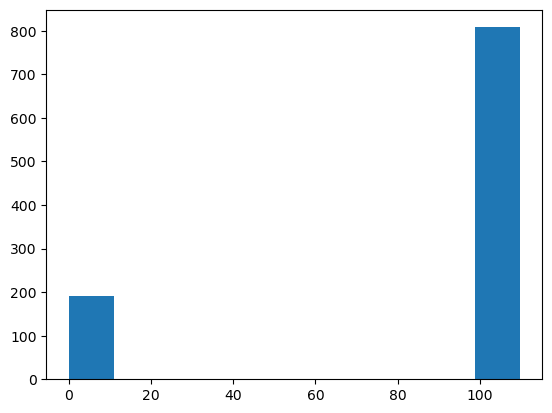

In [18]:
Col = dat.z[:,-1]
Coly = dat.lon[:,-1]
a = plt.hist(Col)

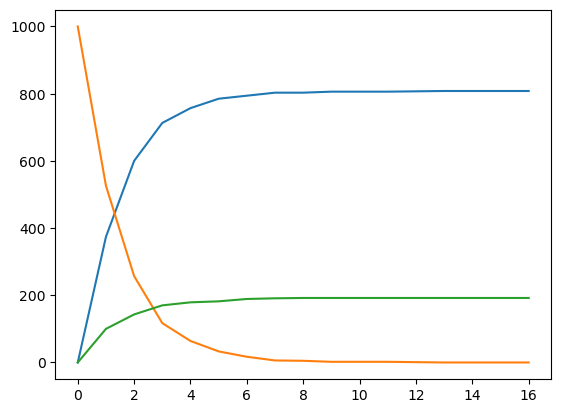

In [19]:
bot = []
col = []
sur = []
for t in range(dat.surf.shape[1]):
    bot.append(np.count_nonzero(dat.surf[:,t]==2))
    col.append(np.count_nonzero(dat.surf[:,t]==0))
    sur.append(np.count_nonzero(dat.surf[:,t]==1))
plt.plot(bot)
plt.plot(col)
plt.plot(sur)

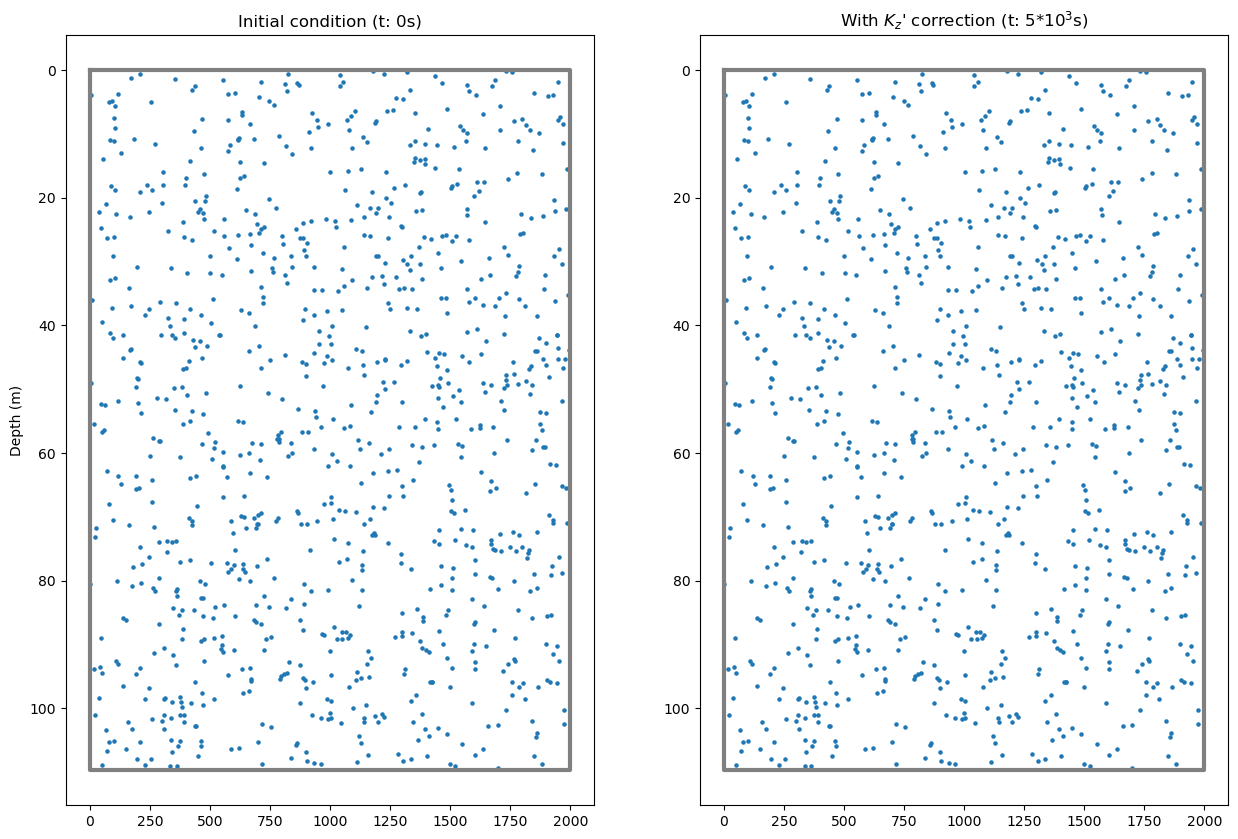

In [20]:
ss =[]
ani = anim2(dat,fps=2)
f = r"/home/jvalenti/MOAD/animations/mix.gif" 
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

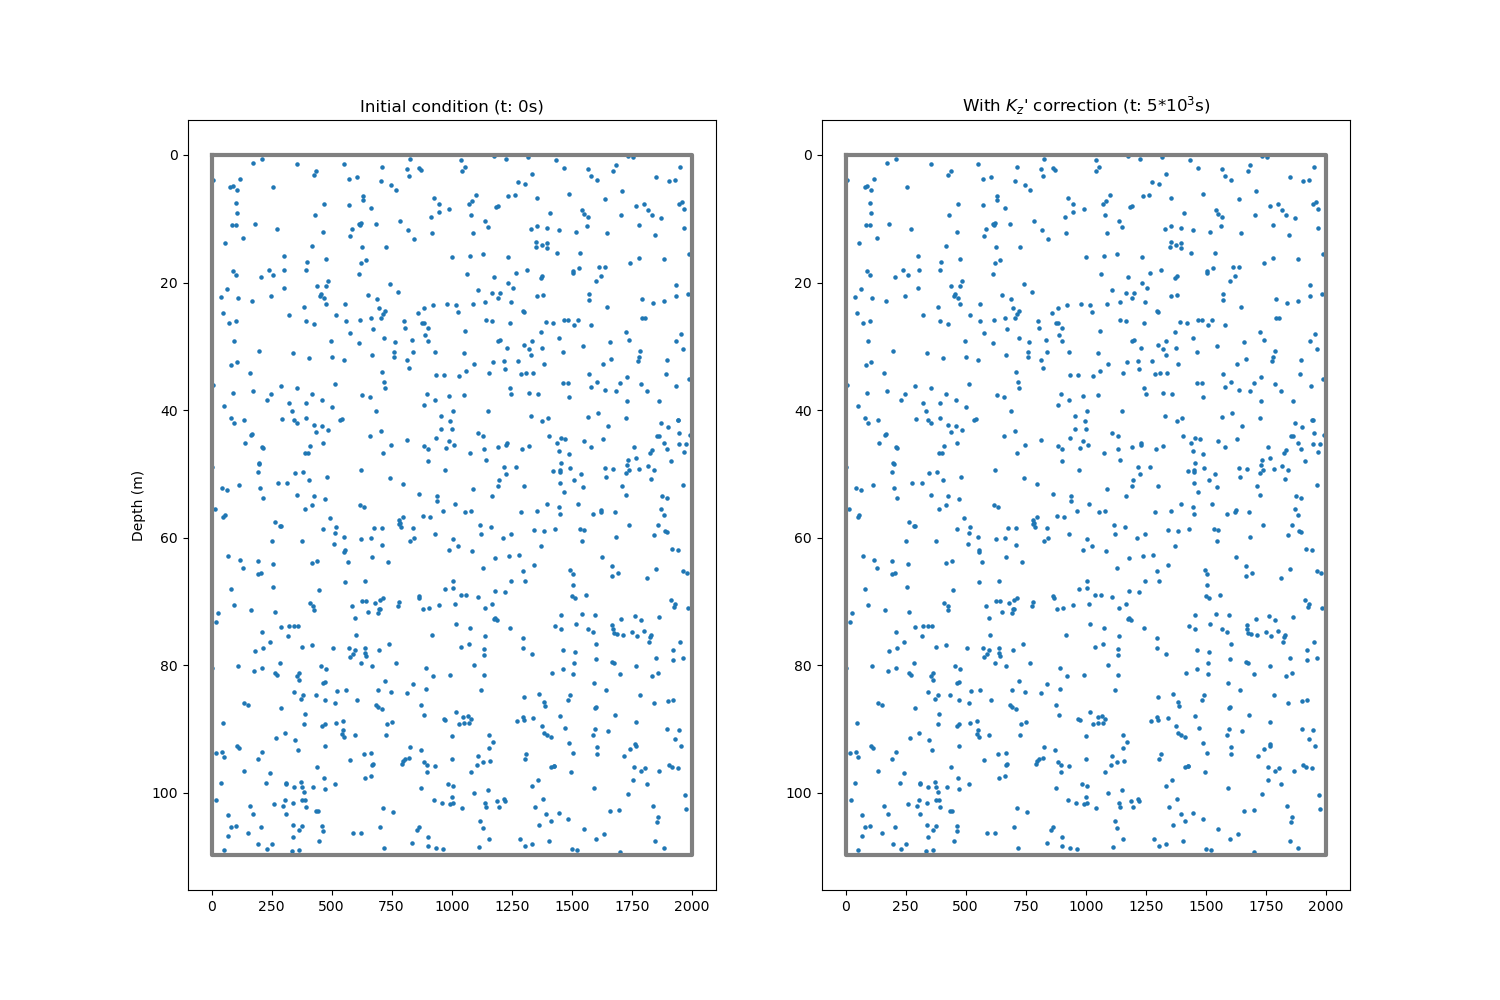

In [21]:
from IPython.display import Image
with open(f,'rb') as anim:
     display(Image(anim.read()))